
# **Financial Time Series prediction using LSTM and Multivariate Linear Regression**



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

##Intro - data exploration, visualization etc

In [65]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sandp500/all_stocks_5yr.csv', index_col = "Name")
df

,date,open,high,low,close,volume
Name,,,,,,
AAL,2013-02-08,15.07,15.12,14.63,14.75,8407500
AAL,2013-02-11,14.89,15.01,14.26,14.46,8882000
AAL,2013-02-12,14.45,14.51,14.10,14.27,8126000
AAL,2013-02-13,14.30,14.94,14.25,14.66,10259500
AAL,2013-02-14,14.94,14.96,13.16,13.99,31879900
...,...,...,...,...,...,...
ZTS,2018-02-01,76.84,78.27,76.69,77.82,2982259
ZTS,2018-02-02,77.53,78.12,76.73,76.78,2595187
ZTS,2018-02-05,76.64,76.92,73.18,73.83,2962031


We'll need this dataset in the end of the work.

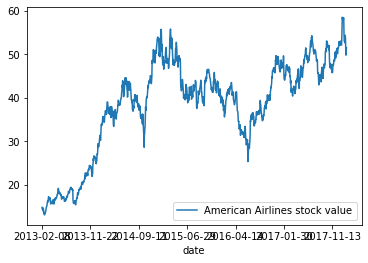

In [66]:
aal = df.loc["AAL"]
aal
aal.plot(x = 'date', y = 'close', label = 'American Airlines stock value')
plt.legend()
plt.show()

In [67]:
#Our main dataset
sp500 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/^GSPC.csv')
sp500

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-02-08,1509.390015,1518.310059,1509.390015,1517.930054,1517.930054,2986150000
1,2013-02-11,1517.930054,1518.310059,1513.609985,1517.010010,1517.010010,2684100000
2,2013-02-12,1517.010010,1522.290039,1515.609985,1519.430054,1519.430054,3414370000
3,2013-02-13,1519.430054,1524.689941,1515.930054,1520.329956,1520.329956,3385880000
4,2013-02-14,1520.329956,1523.140015,1514.020020,1521.380005,1521.380005,3759740000
...,...,...,...,...,...,...,...
1254,2018-02-01,2816.449951,2835.959961,2812.699951,2821.979980,2821.979980,3938450000
1255,2018-02-02,2808.919922,2808.919922,2759.969971,2762.129883,2762.129883,4301130000
1256,2018-02-05,2741.060059,2763.389893,2638.169922,2648.939941,2648.939941,5283460000
1257,2018-02-06,2614.780029,2701.040039,2593.070068,2695.139893,2695.139893,5891660000


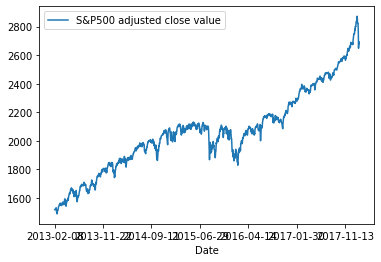

In [68]:
sp500.plot(x = 'Date', y = 'Adj Close', label = 'S&P500 adjusted close value')
plt.legend()
plt.show()

## Data Preprocessing

In [0]:
#Market close data extraction
sp500_close_prices = sp500['Close'].values.astype(float)
#len(sp500_close_prices)

def create_sequences(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

#Data normalization
scaler = MinMaxScaler()
training_data = scaler.fit_transform(sp500_close_prices.reshape(-1,1))

seq_length = 8
x, y = create_sequences(training_data, seq_length)

train_size = 1000
test_size = len(y) - 1000

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

X_train = Variable(torch.Tensor(np.array(x[0:train_size])))
Y_train = Variable(torch.Tensor(np.array(y[0:train_size])))

X_test = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
Y_test = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Model

In [0]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        hidden = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        cell = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (hidden, cell))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        prediction = self.fc(h_out)
        
        return prediction

## Training

In [71]:
num_epochs = 100
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    pred = lstm(X_train)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(pred, Y_train)
    
    loss.backward() #backpropagation
    
    optimizer.step()
    if epoch % 10 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.07279
Epoch: 10, loss: 0.01764
Epoch: 20, loss: 0.01937
Epoch: 30, loss: 0.01615
Epoch: 40, loss: 0.01419
Epoch: 50, loss: 0.01262
Epoch: 60, loss: 0.01046
Epoch: 70, loss: 0.00772
Epoch: 80, loss: 0.00425
Epoch: 90, loss: 0.00090


## Plotting

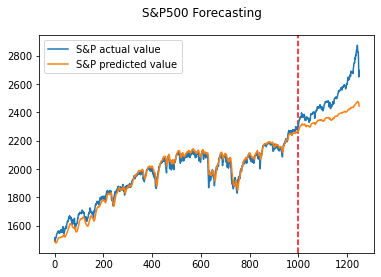

X_test MSE: 25578.0234375
X_test MAE: 136.02183532714844


In [72]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label = "S&P actual value")
plt.plot(data_predict, label = "S&P predicted value")
plt.suptitle('S&P500 Forecasting')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(dataY_plot[1000:], data_predict[1000:])
mae = mean_absolute_error(dataY_plot[1000:], data_predict[1000:])

print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')

MAE of 125 on average is not a very good performance. However, number of epochs was low.

##Wrapping up the prediction process to one single function

In [0]:
def predictor(x_test_size = 259, train_sequence_size = 8, hidden_layer_size = 32, num_epochs = 50):

  sc = MinMaxScaler()
  training_data = sc.fit_transform(sp500_close_prices.reshape(-1,1))

  seq_length = train_sequence_size
  x, y = create_sequences(training_data, seq_length)

  train_size = len(y) - x_test_size
  test_size = x_test_size

  dataX = Variable(torch.Tensor(np.array(x)))
  dataY = Variable(torch.Tensor(np.array(y)))

  X_train = Variable(torch.Tensor(np.array(x[0:train_size])))
  Y_train = Variable(torch.Tensor(np.array(y[0:train_size])))

  X_test = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
  Y_test = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

  class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        hidden = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        cell = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (hidden, cell))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        prediction = self.fc(h_out)
        
        return prediction

  epochs = num_epochs
  learning_rate = 0.01

  input_size = 1
  hidden_size = hidden_layer_size
  num_layers = 1

  num_classes = 1

  lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

  criterion = torch.nn.MSELoss()    # mean-squared error for regression
  optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

  # Error list
  error = []

  # Train the model
  for epoch in range(epochs + 1):
      outputs = lstm(X_train)
      optimizer.zero_grad()
      
      # obtain the loss function
      loss = criterion(outputs, Y_train)
      
      #Backpropagation
      loss.backward()
      
      optimizer.step()
      error.append(loss.item())

      if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
  
  #PLotting the train error
  x = np.arange(0, epochs+1)
  plt.plot(x, error, label = "X_train error")
  plt.suptitle('Model training error')
  plt.legend()
  plt.show()


  #Calculating the predictions
  lstm.eval()
  train_predict = lstm(dataX)

  data_predict = train_predict.data.numpy()
  dataY_plot = dataY.data.numpy()

  data_predict = sc.inverse_transform(data_predict)
  dataY_plot = sc.inverse_transform(dataY_plot)


  #Plotting the predictions
  plt.axvline(x=train_size, c='r', linestyle='--')

  plt.plot(dataY_plot, label = "S&P actual values")
  plt.plot(data_predict, label = "S&P predicted values")
  plt.suptitle('S&P 500 Forecast')
  plt.legend()
  plt.show()

  
  #Test set MSE
  mse = mean_squared_error(dataY_plot[1000:], data_predict[1000:])
  mae = mean_absolute_error(dataY_plot[1000:], data_predict[1000:])

  print(f'X_test MSE: {mse}')
  print(f'X_test MAE: {mae}')

Epoch: 0, loss: 0.22131
Epoch: 50, loss: 0.00526


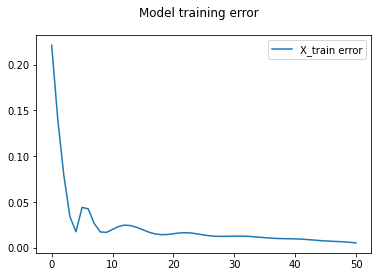

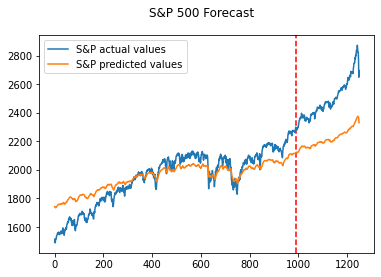

X_test MSE: 83815.8515625
X_test MAE: 279.79400634765625


In [20]:
predictor()

Epoch: 0, loss: 0.11040
Epoch: 50, loss: 0.00063
Epoch: 100, loss: 0.00027
Epoch: 150, loss: 0.00025


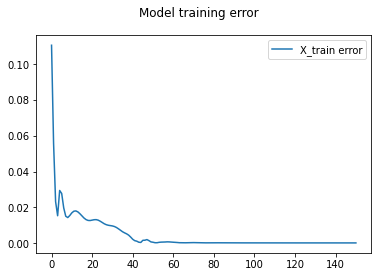

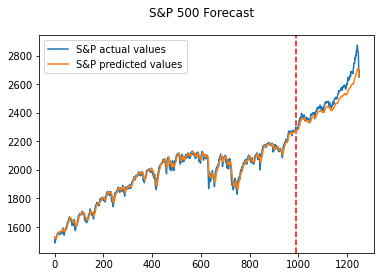

X_test MSE: 3271.16943359375
X_test MAE: 45.87813949584961


In [21]:
predictor(259, 8, 32, 150)

Epoch: 0, loss: 0.13931
Epoch: 50, loss: 0.00080
Epoch: 100, loss: 0.00028
Epoch: 150, loss: 0.00027
Epoch: 200, loss: 0.00025
Epoch: 250, loss: 0.00024


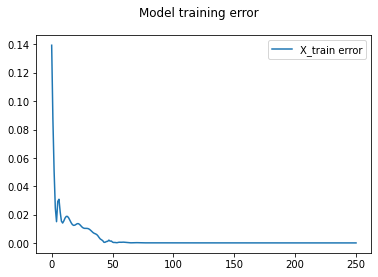

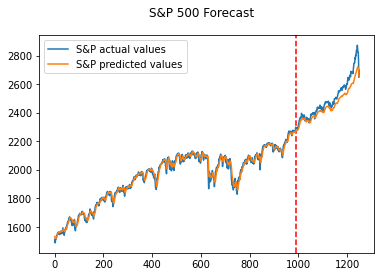

X_test MSE: 2940.6513671875
X_test MAE: 44.10438537597656


In [22]:
predictor(259, 8, 32, 250)

Epoch: 0, loss: 0.06124
Epoch: 50, loss: 0.00060
Epoch: 100, loss: 0.00025
Epoch: 150, loss: 0.00024
Epoch: 200, loss: 0.00023
Epoch: 250, loss: 0.00022
Epoch: 300, loss: 0.00021
Epoch: 350, loss: 0.00020
Epoch: 400, loss: 0.00019
Epoch: 450, loss: 0.00018
Epoch: 500, loss: 0.00017


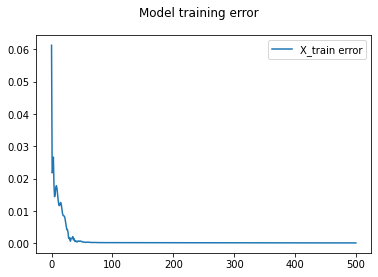

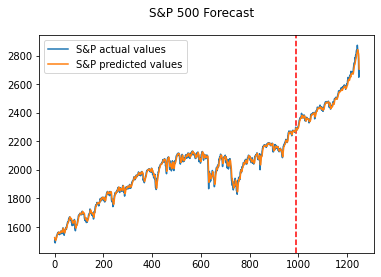

X_test MSE: 284.4483337402344
X_test MAE: 11.629108428955078


In [0]:
predictor(259, 8, 32, 500)

Epoch: 0, loss: 0.14139
Epoch: 50, loss: 0.00161
Epoch: 100, loss: 0.00027
Epoch: 150, loss: 0.00024
Epoch: 200, loss: 0.00023
Epoch: 250, loss: 0.00023
Epoch: 300, loss: 0.00022
Epoch: 350, loss: 0.00021
Epoch: 400, loss: 0.00021
Epoch: 450, loss: 0.00020
Epoch: 500, loss: 0.00019
Epoch: 550, loss: 0.00019
Epoch: 600, loss: 0.00018
Epoch: 650, loss: 0.00018
Epoch: 700, loss: 0.00017
Epoch: 750, loss: 0.00017
Epoch: 800, loss: 0.00016
Epoch: 850, loss: 0.00016
Epoch: 900, loss: 0.00015
Epoch: 950, loss: 0.00015
Epoch: 1000, loss: 0.00015
Epoch: 1050, loss: 0.00015
Epoch: 1100, loss: 0.00014
Epoch: 1150, loss: 0.00020
Epoch: 1200, loss: 0.00014
Epoch: 1250, loss: 0.00014
Epoch: 1300, loss: 0.00013
Epoch: 1350, loss: 0.00013
Epoch: 1400, loss: 0.00013
Epoch: 1450, loss: 0.00014
Epoch: 1500, loss: 0.00013
Epoch: 1550, loss: 0.00013
Epoch: 1600, loss: 0.00013
Epoch: 1650, loss: 0.00013
Epoch: 1700, loss: 0.00013
Epoch: 1750, loss: 0.00013
Epoch: 1800, loss: 0.00013
Epoch: 1850, loss: 0.000

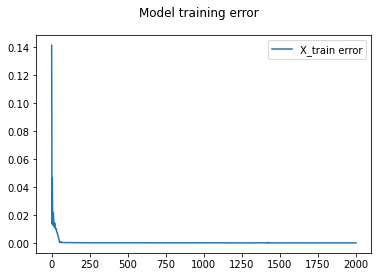

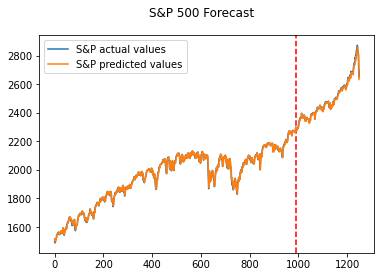

X_test MSE: 237.67825317382812
X_test MAE: 10.512353897094727


In [23]:
predictor(259, 8, 32, 2000)

As you can see, increasing the numer of epochs doesn't lead to lower test error. However, we can see that error does converge in all cases.

# Linear Regression

## Proposition

Now, we propose that similar results can be achieved using multivariate linear regression. The key thing here is to find the stocks having the maximum correlation with S&P500 index. 
Then, after picking 3-5 stocks we can run linear regression, using these stocks as independent variable and S&Pindex as a depedent variable. 
As before, we are going to use first 1000 days as a training set, and then test our model on remaining 259 days.

##Data processing

In [24]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sandp500/all_stocks_5yr.csv', index_col = "Name")
df

,date,open,high,low,close,volume
Name,,,,,,
AAL,2013-02-08,15.07,15.12,14.63,14.75,8407500
AAL,2013-02-11,14.89,15.01,14.26,14.46,8882000
AAL,2013-02-12,14.45,14.51,14.10,14.27,8126000
AAL,2013-02-13,14.30,14.94,14.25,14.66,10259500
AAL,2013-02-14,14.94,14.96,13.16,13.99,31879900
...,...,...,...,...,...,...
ZTS,2018-02-01,76.84,78.27,76.69,77.82,2982259
ZTS,2018-02-02,77.53,78.12,76.73,76.78,2595187
ZTS,2018-02-05,76.64,76.92,73.18,73.83,2962031


In [25]:
dff = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sandp500/all_stocks_5yr.csv')

companies = dff.Name.to_numpy()
companies = np.unique(companies)
companies.shape #total number of companies

(505,)

In [26]:
df.loc["AAPL"]['close'][2] #just a test query

66.8428

In [27]:
#companies = np.unique(df[:][-1])
#companies.shape

#df.shape[0]
stocks = []
i = 0
for j in range(505):
  if(len(df.loc[companies[j]]['close']) == 1259 ):
    stocks.append(df.loc[companies[j]]['close'][:1000] )

len(stocks) # number of stocks with full data on these 5 years

470

##Finding the stocks with maximum correlations

In [0]:
sp500 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/^GSPC.csv')
sp500 = sp500.Close.to_numpy()
#sp500.reshape(1,1000)
correlations = []
for i in range(470):
  npstocks = np.array(stocks[i][:])
  corr = np.corrcoef(sp500[:1000], npstocks)[0][1]
  correlations.append([companies[i], corr])

correlations = np.asarray(correlations)

In [30]:
correlations = correlations[correlations[:,1].argsort()]

correlations[-10:]

array([['APC', '0.9498966265352429'],
       ['BHGE', '0.9529394885335907'],
       ['LNT', '0.9533855257693498'],
       ['RCL', '0.9555444417638277'],
       ['BHF', '0.957549391760878'],
       ['CHTR', '0.9581259923876304'],
       ['APD', '0.9608250121405286'],
       ['ANTM', '0.9656791455331792'],
       ['LOW', '0.9660287551201207'],
       ['FDX', '0.9664386467311166']], dtype='<U22')

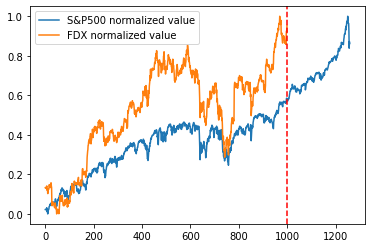

In [34]:
#We use FDX as an example stock
fdx_normalized = scaler.fit_transform(df.loc["FDX"]['close'][:1000].to_numpy().reshape(-1,1))
jpm_normalized = scaler.fit_transform(df.loc["JPM"]['close'][:1000].to_numpy().reshape(-1,1))
sp500_normalized = scaler.fit_transform(sp500.reshape(-1,1))

x1 = range(0,1259)
x2 = range(0,1000)


plt.plot(x1, sp500_normalized, label = "S&P500 normalized value")
plt.plot(x2, fdx_normalized, label = "FDX normalized value")

plt.axvline(x=1000, c='r', linestyle='--')
plt.legend()

## Our Model training

In [0]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [0]:
#So here we use top6 stocks as our training set
fdx_train = (df.loc["FDX"]['close'][1000:1050].to_numpy().reshape(-1,1))
low_train = (df.loc["LOW"]['close'][1000:1050].to_numpy().reshape(-1,1))
antm_train = (df.loc["ANTM"]['close'][1000:1050].to_numpy().reshape(-1,1))

apd_train = (df.loc["APD"]['close'][1000:1050].to_numpy().reshape(-1,1))
chtr_train = (df.loc["CHTR"]['close'][1000:1050].to_numpy().reshape(-1,1))
rcl_train = (df.loc["RCL"]['close'][1000:1050].to_numpy().reshape(-1,1))


fdx_test = (df.loc["FDX"]['close'][1050:1055].to_numpy().reshape(-1,1))
low_test = (df.loc["LOW"]['close'][1050:1055].to_numpy().reshape(-1,1))
antm_test = (df.loc["ANTM"]['close'][1050:1055].to_numpy().reshape(-1,1))

apd_test = (df.loc["APD"]['close'][1050:1055].to_numpy().reshape(-1,1))
chtr_test = (df.loc["CHTR"]['close'][1050:1055].to_numpy().reshape(-1,1))
rcl_test = (df.loc["RCL"]['close'][1050:1055].to_numpy().reshape(-1,1))


In [0]:
X_train = np.concatenate( (fdx_train, low_train, antm_train, apd_train, chtr_train, rcl_train), axis = 1)
X_test = np.concatenate( (fdx_test, low_test, antm_test, apd_test, chtr_test, rcl_test), axis = 1)

In [38]:
X_train.shape

(50, 6)

In [39]:
X_test.shape

(5, 6)

In [40]:
y_train = sp500[1000:1050]
y_train.shape

(50,)

In [41]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train) #Goodness of fit

0.8924611894486367

In [42]:
reg.predict(X_test)

array([2369.13671422, 2348.88328544, 2328.64644928, 2351.54254661,
       2343.33942288])

X_test MSE: 51.85678959831481
X_test MAE: 4.659111773163386


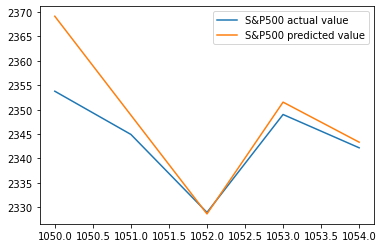

In [44]:
x = range(1050,1055)
plt.plot(x, (sp500[x]), label = "S&P500 actual value")
plt.plot(x, (reg.predict(X_test)), label = "S&P500 predicted value")
plt.legend()

mse = mean_squared_error(sp500[x], reg.predict(X_test))
mae = mean_absolute_error(sp500[x], reg.predict(X_test))

print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')


Amazing! Let's expand the scales:

## Wrapping up

In [0]:
def lin_reg(train_size = 500):
  fdx_train = (df.loc["FDX"]['close'][1000-train_size:1000].to_numpy().reshape(-1,1))
  low_train = (df.loc["LOW"]['close'][1000-train_size:1000].to_numpy().reshape(-1,1))
  antm_train = (df.loc["ANTM"]['close'][1000-train_size:1000].to_numpy().reshape(-1,1))

  apd_train = (df.loc["APD"]['close'][1000-train_size:1000].to_numpy().reshape(-1,1))
  chtr_train = (df.loc["CHTR"]['close'][1000-train_size:1000].to_numpy().reshape(-1,1))
  rcl_train = (df.loc["RCL"]['close'][1000-train_size:1000].to_numpy().reshape(-1,1))


  fdx_test = (df.loc["FDX"]['close'][1000:].to_numpy().reshape(-1,1))
  low_test = (df.loc["LOW"]['close'][1000:].to_numpy().reshape(-1,1))
  antm_test = (df.loc["ANTM"]['close'][1000:].to_numpy().reshape(-1,1))

  apd_test = (df.loc["APD"]['close'][1000:].to_numpy().reshape(-1,1))
  chtr_test = (df.loc["CHTR"]['close'][1000:].to_numpy().reshape(-1,1))
  rcl_test = (df.loc["RCL"]['close'][1000:].to_numpy().reshape(-1,1))


  X_train = np.concatenate( (fdx_train, low_train, antm_train, apd_train, chtr_train, rcl_train), axis = 1)
  X_test = np.concatenate( (fdx_test, low_test, antm_test, apd_test, chtr_test, rcl_test), axis = 1)

  y_train = sp500[1000-train_size:1000]
  y_train.shape

  reg = LinearRegression(fit_intercept = False).fit(X_train, y_train)
  reg.score(X_train, y_train)

  reg.predict(X_test)
  x = range(1000,1259)
  plt.plot(x, sp500[x], label = "S&P500 actual value")
  plt.plot(x, reg.predict(X_test), label = "S&P500 predicted value")
  plt.legend()

  mse = mean_squared_error(sp500[x], reg.predict(X_test))
  mae = mean_absolute_error(sp500[x], reg.predict(X_test))

  print(f'X_test MSE: {mse}')
  print(f'X_test MAE: {mae}')

X_test MSE: 7465.520461260934
X_test MAE: 65.75968581310929


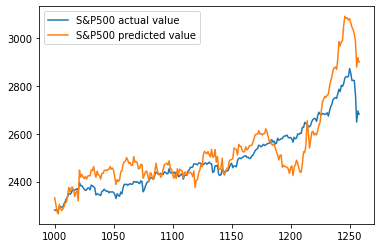

In [46]:
lin_reg(100)

X_test MSE: 12735.596219590516
X_test MAE: 99.19745379822501


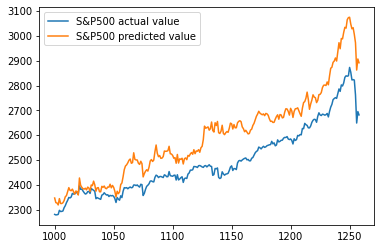

In [47]:
lin_reg(250)

X_test MSE: 36150.23059149216
X_test MAE: 172.54147237310298


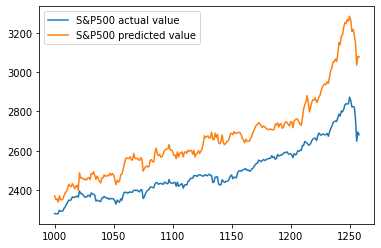

In [48]:
lin_reg(500)

X_test MSE: 9886.936228519255
X_test MAE: 78.23085855646005


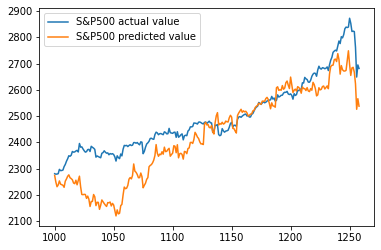

In [49]:
lin_reg(750)

X_test MSE: 109042.08843161777
X_test MAE: 327.30815385597055


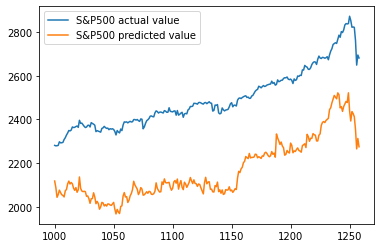

In [50]:
lin_reg(1000)

The last resort here is to include more independent variables



## Updating our regression


In [0]:
def lin_reg_extended(train_size = 500):
  fdx_train = (df.loc["FDX"]['close'][1000-train_size:1000].to_numpy().reshape(-1,1))
  low_train = (df.loc["LOW"]['close'][1000-train_size:1000].to_numpy().reshape(-1,1))
  antm_train = (df.loc["ANTM"]['close'][1000-train_size:1000].to_numpy().reshape(-1,1))

  apd_train = (df.loc["APD"]['close'][1000-train_size:1000].to_numpy().reshape(-1,1))
  chtr_train = (df.loc["CHTR"]['close'][1000-train_size:1000].to_numpy().reshape(-1,1))
  rcl_train = (df.loc["RCL"]['close'][1000-train_size:1000].to_numpy().reshape(-1,1))

  apc_train = (df.loc["APC"]['close'][1000-train_size:1000].to_numpy().reshape(-1,1))
  lnt_train = (df.loc["LNT"]['close'][1000-train_size:1000].to_numpy().reshape(-1,1))




  fdx_test = (df.loc["FDX"]['close'][1000:].to_numpy().reshape(-1,1))
  low_test = (df.loc["LOW"]['close'][1000:].to_numpy().reshape(-1,1))
  antm_test = (df.loc["ANTM"]['close'][1000:].to_numpy().reshape(-1,1))

  apd_test = (df.loc["APD"]['close'][1000:].to_numpy().reshape(-1,1))
  chtr_test = (df.loc["CHTR"]['close'][1000:].to_numpy().reshape(-1,1))
  rcl_test = (df.loc["RCL"]['close'][1000:].to_numpy().reshape(-1,1))

  apc_test = (df.loc["APC"]['close'][1000:].to_numpy().reshape(-1,1))
  lnt_test = (df.loc["LNT"]['close'][1000:].to_numpy().reshape(-1,1))

  X_train = np.concatenate( (fdx_train, low_train, antm_train, apd_train, chtr_train, rcl_train, apc_train, lnt_train), axis = 1)
  X_test = np.concatenate( (fdx_test, low_test, antm_test, apd_test, chtr_test, rcl_test, apc_test, lnt_test), axis = 1)

  y_train = sp500[1000-train_size:1000]
  y_train.shape

  reg = LinearRegression(fit_intercept = False).fit(X_train, y_train)
  reg.score(X_train, y_train)

  reg.predict(X_test)
  x = range(1000,1259)
  plt.plot(x, sp500[x], label = "S&P500 actual value")
  plt.plot(x, reg.predict(X_test), label = "S&P500 predicted value")
  plt.legend()

  mse = mean_squared_error(sp500[x], reg.predict(X_test))
  mae = mean_absolute_error(sp500[x], reg.predict(X_test))

  print(f'X_test MSE: {mse}')
  print(f'X_test MAE: {mae}')

X_test MSE: 38516.297102320124
X_test MAE: 185.88650736376297


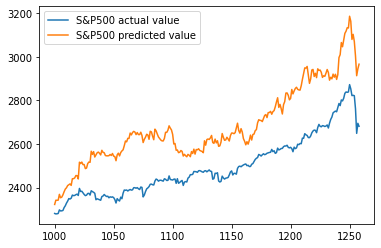

In [53]:
lin_reg_extended(100)

X_test MSE: 1430.4662477692445
X_test MAE: 29.868569030512262


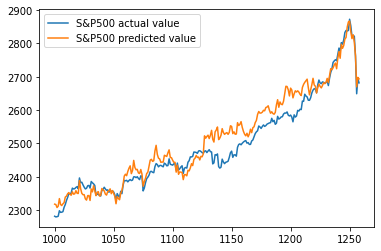

In [54]:
lin_reg_extended(250)

X_test MSE: 24732.754476060836
X_test MAE: 146.62294970718153


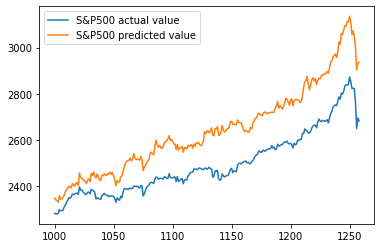

In [55]:
lin_reg_extended(500)

X_test MSE: 2198.165490536054
X_test MAE: 33.391726470090994


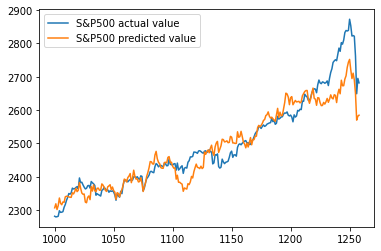

In [56]:
lin_reg_extended(750)

X_test MSE: 6440.9501825990465
X_test MAE: 68.54305492131766


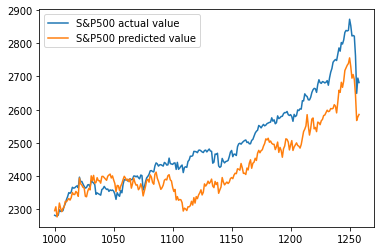

In [57]:
lin_reg_extended(1000)

In short, inclusion of two more variables did lowered the error a little bit.


## Discussion and conclusion

Our LSTM model is a simple LSTM model, which is a current state-of-the art in financial time series prediction. Here, we managed to make the MAE as low as 9.325 (with 2000 epochs), which is a great result and we can claim that our LSTM can be a benchmark (top RNN networks achieve MAE around 5).

Linear regression is relatively easy to use, and it has an easily-manageable error. However, despite the great results shown by it, the assumptions I made about the movement of S&P index can be untrue. Correlation doesn't imply causation, and obviously there are many more factors influencing S&P index, so our regression almost certainly lacks some more factors/features.

However, we still should confess that the performance of multiple linear regression was surprisingly good. Taking our LSTM model here as a benchmark, we haven't managed to get such low errors, but we showed viability of our method of choosing the stocks with maximum correlation with the original S&P index. Moreover, we showed that increasing the number of explanatory variables does lower the error. However, overfitting is the possible issue here.
